## **Phase 1: Data Loading & Initial Exploration**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

import joblib
import os

In [2]:
# Load dataset
# Note: df is short for dataframe for pandas dataframe
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
# See the first 5 rows
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
# See how many rows and columns
df.shape

(7043, 21)

In [4]:
# See column names and types
df.info()

# Notes:
# Dtype => Data Type
# object = Text (strings) or mixed data. Pandas uses object for things that aren’t purely numbers.
# Non-Null Count => Number of non-null values in the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## **Phase 2: Data Quality Assessment**

In [5]:
#  Count missing values in each column
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# Check for duplicate customers
df.duplicated().sum()

np.int64(0)

In [7]:
# See current data types
df.dtypes

# Conclusion:
# - TotalCharges is object, not float

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## **Phase 3: Data Cleaning**

In [8]:
# Convert 'TotalCharges' to numeric, some rows may be blank
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Note: errors='coerce' means that if the conversion fails, the value will be set to NaN

# Now check again for missing values
df.isnull().sum()

# Drop rows with missing TotalCharges
df = df.dropna()

# Check shapes
df.shape

(7032, 21)

In [9]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## **Phase 4: Feature Engineering**

In [10]:
# # CHUNK 1: Basic Data Exploration
# # Purpose: See what columns you have and their types

# print("=== YOUR DATASET OVERVIEW ===")
# print(f"Shape: {df.shape}")
# print(f"Columns: {df.columns.tolist()}")
# print()

# print("=== COLUMN TYPES ===")
# numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
# print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
# print()

# print("=== QUICK PREVIEW ===")
# print(df.head(3))

In [11]:
# # CHUNK 2: Find What Drives Churn
# # Purpose: Discover which existing features matter most

# print("=== CHURN RATES BY CATEGORY ===")
# print("This shows you which categories have highest churn - these are GOLDMINES for features!")
# print()

# # Check categorical columns for churn patterns
# for col in categorical_cols:
#     if col in df.columns:
#         churn_rate = df.groupby(col)['Churn'].value_counts(normalize=True).unstack()
#         churn_rate['Churn_Rate'] = churn_rate['Yes'] / (churn_rate['Yes'] + churn_rate['No'])
        
#         print(f"\n{col} - Churn Rates:")
#         print(churn_rate['Churn_Rate'].sort_values(ascending=False).round(3))
        
#         # Highlight high-risk categories
#         high_risk = churn_rate['Churn_Rate'] > 0.4
#         if high_risk.any():
#             print(f"🚨 HIGH RISK categories in {col}: {high_risk[high_risk].index.tolist()}")

In [12]:
# # CHUNK 3: See How Money Affects Churn
# # Purpose: Financial patterns often drive customer behavior

# print("=== MONEY vs CHURN ANALYSIS ===")

# # Plot 1: Monthly Charges vs Churn
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
# plt.title('Monthly Charges vs Churn')
# plt.ylabel('Monthly Charges ($)')

# # Plot 2: Tenure vs Churn  
# plt.subplot(1, 3, 2)
# sns.boxplot(data=df, x='Churn', y='tenure')
# plt.title('Tenure vs Churn')
# plt.ylabel('Months with Company')

# # Plot 3: Total Charges vs Churn
# plt.subplot(1, 3, 3)
# sns.boxplot(data=df, x='Churn', y='TotalCharges')
# plt.title('Total Charges vs Churn')
# plt.ylabel('Total Charges ($)')

# plt.tight_layout()
# plt.show()

# # Show the actual numbers
# print("\n=== NUMERICAL INSIGHTS ===")
# for col in ['MonthlyCharges', 'tenure', 'TotalCharges']:
#     if col in df.columns:
#         churn_stats = df.groupby('Churn')[col].agg(['mean', 'median']).round(2)
#         print(f"\n{col}:")
#         print(churn_stats)
        
#         # Feature idea generator
#         churned_avg = churn_stats.loc['Yes', 'mean']
#         stayed_avg = churn_stats.loc['No', 'mean']
        
#         if churned_avg > stayed_avg:
#             print(f"💡 FEATURE IDEA: Create 'high_{col.lower()}' flag for values > {churned_avg:.0f}")
#         else:
#             print(f"💡 FEATURE IDEA: Create 'low_{col.lower()}' flag for values < {churned_avg:.0f}")

In [13]:
# # CHUNK 4: Create Your First Feature - Service Count
# # Purpose: Customers with more services are usually stickier (less likely to churn)

# print("=== CREATING SERVICE COUNT FEATURE ===")
# print("Theory: More services = harder to leave = lower churn")
# print()

# # Step 1: Find all service columns
# service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
#                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# # Step 2: Check what values these columns have
# print("Service column values:")
# for col in service_cols[:3]:  # Just show first 3 for brevity
#     if col in df.columns:
#         print(f"{col}: {df[col].unique()}")
# print()

# # Step 3: Convert to 1/0 format for counting
# print("Converting services to 1/0...")
# df_temp = df.copy()  # Work on copy first

# service_count = 0
# for col in service_cols:
#     if col in df.columns:
#         if col == 'InternetService':
#             # Special case: 'No' = 0, any internet service = 1
#             df_temp[col + '_binary'] = (df_temp[col] != 'No').astype(int)
#         else:
#             # Regular case: 'Yes' = 1, 'No' = 0
#             df_temp[col + '_binary'] = (df_temp[col] == 'Yes').astype(int)
        
#         service_count += df_temp[col + '_binary']

# # Step 4: Create the feature
# df_temp['total_services'] = service_count

# # Step 5: Test if it works
# print("✅ Feature created! Sample results:")
# print(df_temp[['total_services']].head())
# print()
# print("Distribution of service counts:")
# print(df_temp['total_services'].value_counts().sort_index())
# print()

# # Step 6: Validate the theory - does it predict churn?
# print("=== TESTING THE THEORY ===")
# churn_by_services = df_temp.groupby('total_services')['Churn'].value_counts(normalize=True).unstack()
# churn_by_services['Churn_Rate'] = churn_by_services['Yes'] / (churn_by_services['Yes'] + churn_by_services['No'])

# print("Churn rate by number of services:")
# print(churn_by_services['Churn_Rate'].round(3))

# if churn_by_services['Churn_Rate'].iloc[0] > churn_by_services['Churn_Rate'].iloc[-1]:
#     print("✅ THEORY CONFIRMED: Fewer services = higher churn!")
# else:
#     print("❌ Theory not confirmed - investigate further")

In [14]:
# # CHUNK 5: Create Risk Profile Feature
# # Purpose: Combine multiple risky factors into one powerful feature

# print("=== CREATING RISK PROFILE FEATURE ===")
# print("Theory: Month-to-month + New customer + High charges = VERY RISKY")
# print()

# # Step 1: Define what makes a customer risky
# print("Risk factors:")
# print("1. Contract = Month-to-month (no commitment)")
# print("2. tenure <= 12 months (new customer)")
# print("3. MonthlyCharges > 70 (expensive)")
# print()

# # Step 2: Check each risk factor individually
# df_temp = df.copy()

# risk1 = df_temp['Contract'] == 'Month-to-month'
# risk2 = df_temp['tenure'] <= 12
# risk3 = df_temp['MonthlyCharges'] > 70

# print("Individual risk factor churn rates:")
# print(f"Month-to-month: {df_temp[risk1]['Churn'].value_counts(normalize=True).get('Yes', 0):.3f}")
# print(f"New customer: {df_temp[risk2]['Churn'].value_counts(normalize=True).get('Yes', 0):.3f}")
# print(f"High charges: {df_temp[risk3]['Churn'].value_counts(normalize=True).get('Yes', 0):.3f}")
# print()

# # Step 3: Combine all risk factors
# df_temp['high_risk_profile'] = (risk1 & risk2 & risk3).astype(int)

# print("=== RISK PROFILE RESULTS ===")
# print(f"High risk customers: {df_temp['high_risk_profile'].sum()} out of {len(df_temp)}")
# print(f"Percentage: {df_temp['high_risk_profile'].mean()*100:.1f}%")
# print()

# # Step 4: Test the power of this feature
# risk_churn = df_temp.groupby('high_risk_profile')['Churn'].value_counts(normalize=True).unstack()
# risk_churn['Churn_Rate'] = risk_churn['Yes'] / (risk_churn['Yes'] + risk_churn['No'])

# print("Churn rates:")
# print(f"Normal customers (0): {risk_churn.loc[0, 'Churn_Rate']:.3f}")
# print(f"High risk customers (1): {risk_churn.loc[1, 'Churn_Rate']:.3f}")

# improvement = risk_churn.loc[1, 'Churn_Rate'] / risk_churn.loc[0, 'Churn_Rate']
# print(f"\n🎯 HIGH RISK CUSTOMERS ARE {improvement:.1f}x MORE LIKELY TO CHURN!")

# if improvement > 2:
#     print("✅ EXCELLENT FEATURE! This will help your model a lot!")
# elif improvement > 1.5:
#     print("✅ Good feature! This should improve your model.")
# else:
#     print("⚠️ Weak feature - try different combinations.")

In [15]:
# # CHUNK 6: Create Value Perception Features
# # Purpose: Calculate ratios that show if customers feel they get good value

# print("=== CREATING VALUE-BASED FEATURES ===")
# print("Theory: Customers leave when they feel they're not getting good value for money")
# print()

# df_temp = df.copy()

# # Feature 1: Monthly charges per tenure month
# print("Feature 1: Average monthly spend over customer lifetime")
# df_temp['avg_monthly_spend'] = df_temp['TotalCharges'] / (df_temp['tenure'] + 1)  # +1 to avoid division by 0

# print("Sample values:")
# print(df_temp[['MonthlyCharges', 'TotalCharges', 'tenure', 'avg_monthly_spend']].head())
# print()

# # Feature 2: Charges per service (if we have service count)
# if 'total_services' not in df_temp.columns:
#     # Quick service count for this example
#     service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup']
#     service_count = 0
#     for col in service_cols:
#         if col in df.columns:
#             if col == 'InternetService':
#                 service_count += (df[col] != 'No').astype(int)
#             else:
#                 service_count += (df[col] == 'Yes').astype(int)
#     df_temp['total_services'] = service_count

# print("Feature 2: Price per service")
# df_temp['price_per_service'] = df_temp['MonthlyCharges'] / (df_temp['total_services'] + 1)

# print("Sample values:")
# print(df_temp[['MonthlyCharges', 'total_services', 'price_per_service']].head())
# print()

# # Feature 3: Value bins
# print("Feature 3: Value perception categories")
# df_temp['value_perception'] = pd.cut(df_temp['price_per_service'], 
#                                    bins=[0, 15, 25, 40, 1000],
#                                    labels=['Great_Value', 'Good_Value', 'Fair_Value', 'Poor_Value'])

# print("Value perception distribution:")
# print(df_temp['value_perception'].value_counts())
# print()

# # Test these features
# print("=== TESTING VALUE FEATURES ===")

# # Test avg_monthly_spend
# print("1. Average monthly spend vs churn:")
# spend_churn = df_temp.groupby('Churn')['avg_monthly_spend'].mean()
# print(f"Churned customers: ${spend_churn['Yes']:.2f}/month")
# print(f"Stayed customers: ${spend_churn['No']:.2f}/month")
# print()

# # Test value perception
# print("2. Value perception vs churn:")
# value_churn = df_temp.groupby('value_perception')['Churn'].value_counts(normalize=True).unstack()
# if 'Yes' in value_churn.columns:
#     value_churn['Churn_Rate'] = value_churn['Yes'] / (value_churn['Yes'] + value_churn['No'])
#     print("Churn rates by value perception:")
#     print(value_churn['Churn_Rate'].round(3))
    
#     if value_churn['Churn_Rate'].iloc[-1] > value_churn['Churn_Rate'].iloc[0]:
#         print("✅ CONFIRMED: Poor value perception leads to higher churn!")
#     else:
#         print("❌ Hypothesis not confirmed")

In [16]:
# # ## **Phase 4: Feature Engineering**

# def create_churn_features(df):
#     """Create comprehensive features for churn prediction"""
#     df = df.copy()
    
#     # 1. Tenure-based features
#     df['is_new_customer'] = (df['tenure'] <= 6).astype(int)
#     df['is_long_term'] = (df['tenure'] >= 24).astype(int)
#     df['monthly_per_tenure'] = df['MonthlyCharges'] / (df['tenure'] + 1)
#     df['total_per_tenure'] = df['TotalCharges'] / (df['tenure'] + 1)
    
#     # 2. Service usage
#     # First, let's check what values we actually have
#     service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
#                     'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    
#     # Handle different types of values in service columns
#     df_services = df[service_cols].copy()
#     for col in service_cols:
#         if col == 'InternetService':
#             # InternetService has 'DSL', 'Fiber optic', 'No' - treat 'No' as 0, others as 1
#             df_services[col] = (df_services[col] != 'No').astype(int)
#         else:
#             # Other columns should be Yes/No, but let's be safe
#             df_services[col] = df_services[col].replace({'Yes': 1, 'No': 0})
#             # Handle any unexpected values
#             df_services[col] = pd.to_numeric(df_services[col], errors='coerce').fillna(0)
    
#     df['total_services'] = df_services.sum(axis=1)
#     df['service_utilization'] = df['total_services'] / 8
    
#     # 3. Financial features
#     df['is_high_spender'] = (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)).astype(int)
#     df['charges_per_service'] = df['MonthlyCharges'] / (df['total_services'] + 1)
    
#     # 4. Risk combinations
#     df['high_risk'] = (
#         (df['Contract'] == 'Month-to-month') & 
#         (df['tenure'] <= 12) & 
#         (df['MonthlyCharges'] > 65)
#     ).astype(int)
    
#     # 5. Satisfaction proxies
#     df['likely_satisfied'] = (
#         (df['Contract'] != 'Month-to-month') &
#         (df['TechSupport'] == 'Yes')
#     ).astype(int)
    
#     # 6. Binned features
#     df['tenure_group'] = pd.cut(df['tenure'], 
#                                bins=[0, 6, 12, 24, 100], 
#                                labels=['New', 'Growing', 'Mature', 'Veteran'])
    
#     df['charges_group'] = pd.cut(df['MonthlyCharges'],
#                                 bins=[0, 35, 55, 75, 120],
#                                 labels=['Budget', 'Standard', 'Premium', 'Enterprise'])
    
#     return df

# # Apply feature engineering
# print("Original dataset shape:", df.shape)
# df = create_churn_features(df)
# print("Dataset shape after feature engineering:", df.shape)
# print("New features created!")

# # Check some of the new features
# print("\nSample of new features:")
# new_features = ['is_new_customer', 'total_services', 'high_risk', 'likely_satisfied']
# print(df[new_features].head())

## **Phase 5: Data Visualization & Exploration**

Text(0.5, 1.0, 'Churn by Contract Type')

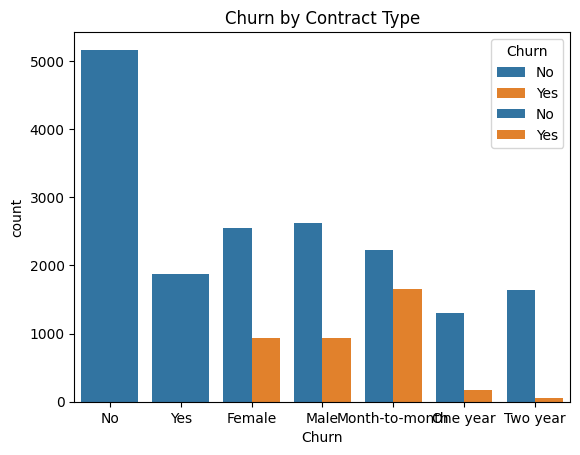

In [17]:
# Plot churn count
sns.countplot(x='Churn', data=df)
plt.title("Churn Count")

# Plot churn by gender
sns.countplot(x='gender', hue='Churn', data=df)
plt.title("Churn by Gender")

# Plot churn by Contract type
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn by Contract Type")

## **Phase 6: Data Preprocessing**

In [18]:
# Drop customerID (not useful)
df.drop(['customerID'], axis=1, inplace=True)

In [19]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(num_cols)
print(categorical_cols)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [20]:
# Dynamic column classification based on data types and unique values
feature_cols = [col for col in categorical_cols if col != 'Churn']
target_col = 'Churn'

# Binary columns: columns with only 2 unique values (Yes/No)
binary_cols = []
for col in feature_cols:
    unique_vals = df[col].nunique()
    if unique_vals == 2:
        binary_cols.append(col)

# One-hot columns: columns with more than 2 unique values
onehot_cols = []
for col in feature_cols:
    unique_vals = df[col].nunique()
    if unique_vals > 2:
        onehot_cols.append(col)

print("Binary columns (2 unique values):", binary_cols)
print("One-hot columns (>2 unique values):", onehot_cols)

Binary columns (2 unique values): ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
One-hot columns (>2 unique values): ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [21]:
# Numerical pipeline
num_pipeline = Pipeline([ # pipeline means create a step-by-step process
    ('imputer', SimpleImputer(strategy='median')) # replace missing num with middle value
])

# OneHot pipeline (for nominal categorical features)
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoding', OneHotEncoder())
])

# Binary/Ordinal pipeline
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoding', OrdinalEncoder())
])

# Master controller that decides which columns go to which processing station
processing = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('onehot', onehot_pipeline, onehot_cols),
    ('ordinal', binary_pipeline, binary_cols)
], remainder='passthrough')

processing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_encoding',
                                                  OneHotEncoder())]),
                                 ['MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaymentMethod']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary_encoding',
                                                  OrdinalEncoder())]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'PaperlessBilling'])])

In [22]:
# Separate What You Want to Predict
X = df.drop('Churn', axis=1)  # Everything EXCEPT 'Churn' column
y = df['Churn']               # ONLY the 'Churn' column

# Note:
# Why X and y?
# This comes from math notation: y = f(X) means "y depends on X"
# X: Independent variables (customer info)
# y: Dependent variable (churn yes/no)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Clean the data
X_train_cleaned = processing.fit_transform(X_train)
X_test_cleaned = processing.transform(X_test)

# Convert target labels to numerical for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [23]:
# Test if data is preprocessed
print("Original shape:", X_train.shape)
print("Processed shape:", X_train_cleaned.shape)

# If OneHot worked, processed data should have MORE columns
# Example: Original (7000, 20) → Processed (7000, 45)

Original shape: (5625, 19)
Processed shape: (5625, 40)


In [24]:
# Another way to test if data is preprocessed
# Test 1: All numbers?
processed_sample = pd.DataFrame(X_train_cleaned)
print("Any non-numeric values?", processed_sample.select_dtypes(include=['object']).shape[1] > 0)

# Test 2: Can we scale without errors?
try:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_train_cleaned)
    print("✅ Pipeline worked! Data is ready for ML")
except ValueError as e:
    print(f"❌ Pipeline failed: {e}")

Any non-numeric values? False
✅ Pipeline worked! Data is ready for ML


In [25]:
# Check if your data is imbalanced
print("Churn distribution:")
print(y_train.value_counts())
print("\nPercentages:")
print(y_train.value_counts(normalize=True) * 100)

Churn distribution:
Churn
No     4130
Yes    1495
Name: count, dtype: int64

Percentages:
Churn
No     73.422222
Yes    26.577778
Name: proportion, dtype: float64


In [26]:
# Resampling because the data is imbalanced
smote = SMOTE(random_state=12)
X_resampled, y_resampled = smote.fit_resample(X_train_cleaned, y_train)

# Notes:
# SMOTE = "Synthetic Minority Oversampling TEchnique"
# What it means: "I'm a tool that creates fake examples of rare cases"

# Scaling
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test_cleaned)

## **Phase 7: Model Training**

In [27]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_resampled_scaled, y_resampled)

# Train SVM model  
print("Training SVM model...")

svm_model = SVC(kernel='linear', random_state=42, probability=True)
svm_model.fit(X_resampled_scaled, y_resampled)

# Train XGBoost model
print("Training XGBoost model...")
# Calculate class weight for imbalanced data
pos_weight = (y_train == 'No').sum() / (y_train == 'Yes').sum()
xgb_model = XGBClassifier(
    scale_pos_weight=pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_cleaned, y_train_encoded)

# Note: xgb model handle imbalanced data better internally through scale_pos_weight

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles imbalance
    random_state=42
)
rf_model.fit(X_train_cleaned, y_train)

# Create voting classifier with your existing models
print("Training Voting Classifier...")
voting_model = VotingClassifier([
    ('lr', lr_model),       # Logistic Regression
    ('svm', svm_model),     # SVM
    ('rf', rf_model)        # Random Forest
    # Note: Excluding XGBoost because it uses different data format
], voting='soft')  # 'soft' uses probabilities, 'hard' uses direct votes
voting_model.fit(X_resampled_scaled, y_resampled)

print("Model training completed!")

Training Logistic Regression model...
Training SVM model...
Training XGBoost model...
Training Random Forest model...
Training Voting Classifier...
Model training completed!


## **Phase 8: Model Evaluation**

In [28]:
# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_xgb_encoded = xgb_model.predict(X_test_cleaned)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)  # Convert back to 'Yes'/'No'
y_pred_rf = rf_model.predict(X_test_cleaned)
y_pred_voting = voting_model.predict(X_test_scaled)

In [29]:
# Evaluation function for cleaner code
def evaluate_model(model, y_true, y_pred, model_name, X_test_data, use_encoded=False):
    """Evaluate a single model and return metrics"""
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='Yes')
    recall = recall_score(y_true, y_pred, pos_label='Yes')
    f1 = f1_score(y_true, y_pred, pos_label='Yes')
    
    # ROC AUC (handle different data formats)
    if use_encoded:
        # For XGBoost and Random Forest (using encoded test data)
        y_true_encoded = label_encoder.transform(y_true)
        roc_auc = roc_auc_score(y_true_encoded, model.predict_proba(X_test_data)[:,1])
    else:
        # For Logistic Regression and SVM (using scaled test data)
        roc_auc = roc_auc_score(y_true, model.predict_proba(X_test_data)[:,1])
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Evaluate all models
print("\n" + "="*60)
print("📊 MODEL EVALUATION RESULTS")
print("="*60)

# Evaluate each model
lr_results = evaluate_model(lr_model, y_test, y_pred_lr, "Logistic Regression", X_test_scaled, use_encoded=False)
svm_results = evaluate_model(svm_model, y_test, y_pred_svm, "SVM", X_test_scaled, use_encoded=False)
xgb_results = evaluate_model(xgb_model, y_test, y_pred_xgb, "XGBoost", X_test_cleaned, use_encoded=True)
rf_results = evaluate_model(rf_model, y_test, y_pred_rf, "Random Forest", X_test_cleaned, use_encoded=True)
voting_results = evaluate_model(voting_model, y_test, y_pred_voting, "Voting Classifier", X_test_scaled, use_encoded=False)

# Display detailed results for each model
models_to_evaluate = [lr_results, svm_results, xgb_results, rf_results, voting_results]

for model_result in models_to_evaluate:
    print(f"\n{model_result['Model'].upper()}")
    print("-" * 40)
    print(f"Recall:    {model_result['Recall']:.4f}")
    # print(f"Accuracy:  {model_result['Accuracy']:.4f}")
    # print(f"Precision: {model_result['Precision']:.4f}")
    # print(f"F1 Score:  {model_result['F1 Score']:.4f}")
    # print(f"ROC AUC:   {model_result['ROC AUC']:.4f}")
    
    # Get predictions for classification report
    if model_result['Model'] == "Logistic Regression":
        y_pred_for_report = y_pred_lr
    elif model_result['Model'] == "SVM":
        y_pred_for_report = y_pred_svm
    elif model_result['Model'] == "XGBoost":
        y_pred_for_report = y_pred_xgb
    else:  # Random Forest
        y_pred_for_report = y_pred_rf
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_for_report))


📊 MODEL EVALUATION RESULTS

LOGISTIC REGRESSION
----------------------------------------
Recall:    0.7914

Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.71      0.79      1033
         Yes       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407


SVM
----------------------------------------
Recall:    0.8155

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.64      0.75      1033
         Yes       0.45      0.82      0.58       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.78      0.69      0.70      1407


XGBOOST
----------------------------------------
Recall:    0.6711

Classification Report:
              precision    recall 

In [30]:
# Model comparison summary
print("\n" + "="*60)
print("🏆 MODEL COMPARISON SUMMARY")
print("="*60)

# Create comparison DataFrame
comparison_data = []
for model_result in models_to_evaluate:
    comparison_data.append([
        model_result['Model'],
        model_result['Accuracy'],
        model_result['Precision'],
        model_result['Recall'],
        model_result['F1 Score'],
        model_result['ROC AUC']
    ])

comparison_df = pd.DataFrame(comparison_data, 
                           columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
print(comparison_df.round(4))


🏆 MODEL COMPARISON SUMMARY
                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Logistic Regression    0.7285     0.4933  0.7914    0.6078   0.8335
1                  SVM    0.6866     0.4505  0.8155    0.5804   0.8252
2              XGBoost    0.7427     0.5122  0.6711    0.5810   0.8104
3        Random Forest    0.7875     0.6316  0.4813    0.5463   0.8156
4    Voting Classifier    0.7413     0.5088  0.7701    0.6128   0.8304


In [34]:
# Find best performing model
best_model_idx = comparison_df['F1 Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1_score = comparison_df.loc[best_model_idx, 'F1 Score']

print(f"\n🥇 BEST PERFORMING MODEL:")
print(f"   {best_model_name} with F1 Score: {best_f1_score:.4f}")


🥇 BEST PERFORMING MODEL:
   Voting Classifier with F1 Score: 0.6128


## **Phase 9: Model Optimization**

In [37]:
# Simple SVM threshold optimization
print("\n" + "="*60)
print("🎯 SVM THRESHOLD OPTIMIZATION - FINDING BEST RECALL")
print("="*60)

# Get SVM probabilities (using the same data format as your existing code)
svm_probs = svm_model.predict_proba(X_test_scaled)[:, 1]

# Test different thresholds and find best recall
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_recall = 0
best_threshold = 0.5
best_metrics = {}

print("Threshold | Recall  | Precision | F1-Score")
print("-" * 45)

for threshold in thresholds:
    # Apply threshold
    predictions = (svm_probs >= threshold).astype(int)
    pred_labels = ['Yes' if pred == 1 else 'No' for pred in predictions]
    
    # Calculate metrics
    recall = recall_score(y_test, pred_labels, pos_label='Yes')
    precision = precision_score(y_test, pred_labels, pos_label='Yes')
    f1 = f1_score(y_test, pred_labels, pos_label='Yes')
    
    print(f"{threshold:^9} | {recall:.4f}  | {precision:.4f}    | {f1:.4f}")
    
    # Track best recall
    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_metrics = {'recall': recall, 'precision': precision, 'f1': f1}

print(f"\n🏆 BEST SVM THRESHOLD: {best_threshold}")
print(f"   Recall: {best_metrics['recall']:.4f}")
print(f"   Precision: {best_metrics['precision']:.4f}")
print(f"   F1-Score: {best_metrics['f1']:.4f}")

# Show high-risk customers
high_risk_count = (svm_probs >= best_threshold).sum()
print(f"\n🔴 HIGH-RISK CUSTOMERS (Probability >= {best_threshold}): {high_risk_count}")

print("✅ SVM threshold optimization completed!")
print(f"💡 Use threshold {best_threshold} for production deployment")


🎯 SVM THRESHOLD OPTIMIZATION - FINDING BEST RECALL
Threshold | Recall  | Precision | F1-Score
---------------------------------------------
   0.1    | 0.9920  | 0.3071    | 0.4690
   0.2    | 0.9920  | 0.3071    | 0.4690
   0.3    | 0.8155  | 0.4505    | 0.5804
   0.4    | 0.8155  | 0.4505    | 0.5804
   0.5    | 0.8155  | 0.4505    | 0.5804
   0.6    | 0.8155  | 0.4505    | 0.5804
   0.7    | 0.8155  | 0.4505    | 0.5804
   0.8    | 0.0000  | 0.0000    | 0.0000
   0.9    | 0.0000  | 0.0000    | 0.0000

🏆 BEST SVM THRESHOLD: 0.1
   Recall: 0.9920
   Precision: 0.3071
   F1-Score: 0.4690

🔴 HIGH-RISK CUSTOMERS (Probability >= 0.1): 1208
✅ SVM threshold optimization completed!
💡 Use threshold 0.1 for production deployment


d:\cs\nti\churn prediction project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\cs\nti\churn prediction project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Saving the model**

In [50]:
# Save the optimized SVM model with best threshold
print("\n" + "="*60)
print("💾 SAVING OPTIMIZED SVM MODEL")
print("="*60)

# Create models directory if it doesn't exist
models_path = "../models"
os.makedirs(models_path, exist_ok=True)

# Save the SVM model
svm_model_path = f"{models_path}/svm_model.pkl"
joblib.dump(svm_model, svm_model_path)
print(f"✅ SVM model saved to: {svm_model_path}")

# Save the best threshold value
threshold_path = f"{models_path}/svm_threshold.txt"
with open(threshold_path, 'w') as f:
    f.write(str(best_threshold))
print(f"✅ Best threshold saved to: {threshold_path}")

# Save the scaler for preprocessing new data
scaler_path = f"{models_path}/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

# Save the preprocessing pipeline
processing_path = f"{models_path}/preprocessing.pkl"
joblib.dump(processing, processing_path)
print(f"✅ Preprocessing pipeline saved to: {processing_path}")

print(f"\n🎯 Model deployment ready!")
print(f"   - Use threshold: {best_threshold}")
print(f"   - Model file: {svm_model_path}")
print(f"   - For new predictions: load model and apply threshold {best_threshold}")

# Function to load and use the saved model
def load_and_predict_svm(customer_data):
    """
    Load the saved SVM model and make predictions on new customer data
    
    Parameters:
    customer_data: DataFrame with customer features (same columns as training data)
    
    Returns:
    predictions: Churn predictions (Yes/No)
    probabilities: Churn probabilities
    risk_scores: Risk scores based on threshold
    """
    try:
        # Load the saved components
        svm_model = joblib.load(f"{models_path}/svm_model.pkl")
        scaler = joblib.load(f"{models_path}/scaler.pkl")
        processing = joblib.load(f"{models_path}/preprocessing.pkl")
        
        # Load the best threshold
        with open(f"{models_path}/svm_threshold.txt", 'r') as f:
            best_threshold = float(f.read().strip())
        
        print(f"✅ Model loaded successfully with threshold: {best_threshold}")
        
        # Preprocess the new data
        customer_processed = processing.transform(customer_data)
        customer_scaled = scaler.transform(customer_processed)
        
        # Get probabilities
        probabilities = svm_model.predict_proba(customer_scaled)[:, 1]
        
        # Apply the optimized threshold
        predictions = ['Yes' if prob >= best_threshold else 'No' for prob in probabilities]
        
        # Create risk scores
        risk_scores = []
        for prob in probabilities:
            if prob >= best_threshold:
                if prob >= 0.8:
                    risk_scores.append('Very High Risk')
                elif prob >= 0.6:
                    risk_scores.append('High Risk')
                else:
                    risk_scores.append('Medium Risk')
            else:
                if prob <= 0.2:
                    risk_scores.append('Very Low Risk')
                else:
                    risk_scores.append('Low Risk')
        
        return predictions, probabilities, risk_scores
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None

# Example usage (uncomment to test)
# print("\n" + "="*60)
# print("🧪 TESTING MODEL LOADING")
# print("="*60)
# 
# # Create sample customer data (replace with your actual data)
# sample_customer = pd.DataFrame({
#     'gender': ['Male'],
#     'SeniorCitizen': [0],
#     'Partner': ['Yes'],
#     'Dependents': ['No'],
#     'tenure': [12],
#     'PhoneService': ['Yes'],
#     'InternetService': ['DSL'],
#     'OnlineSecurity': ['No'],
#     'OnlineBackup': ['No'],
#     'DeviceProtection': ['No'],
#     'TechSupport': ['No'],
#     'StreamingTV': ['No'],
#     'StreamingMovies': ['No'],
#     'Contract': ['Month-to-month'],
#     'MonthlyCharges': [65.0],
#     'TotalCharges': [780.0]
# })
# 
# # Make prediction
# predictions, probabilities, risk_scores = load_and_predict_svm(sample_customer)
# 
# if predictions is not None:
#     print(f"Sample customer prediction: {predictions[0]}")
#     print(f"Churn probability: {probabilities[0]:.3f}")
#     print(f"Risk level: {risk_scores[0]}")


💾 SAVING OPTIMIZED SVM MODEL
✅ SVM model saved to: ../models/svm_model.pkl
✅ Best threshold saved to: ../models/svm_threshold.txt
✅ Scaler saved to: ../models/scaler.pkl
✅ Preprocessing pipeline saved to: ../models/preprocessing.pkl

🎯 Model deployment ready!
   - Use threshold: 0.1
   - Model file: ../models/svm_model.pkl
   - For new predictions: load model and apply threshold 0.1
